In [145]:
import geopandas as gpd
from shapely.geometry import Polygon, LineString, box
import random
import matplotlib.pyplot as plt
import json
import pandas as pd

## 1. Загрузка и превью данных

In [146]:
with open('sample.geojson', 'r', encoding='windows-1251') as f:
    data = json.load(f)

# print(json.dumps(data, ensure_ascii=False, indent=4))

In [147]:
def Create_gdf(data:dict):

    '''Функция получает на вход данные в формате dict и возвращает геодатасет с размеченными областями'''

    geometries = []
    names = []
    restrictions = []

    for feature in data['features']: # Итерируем по фичам
        geom_type = feature['geometry']['type'] # Тип области
        restriction = feature['properties'].get('restriction', None) # Получаем ограничение на область. Если ограничений нет - None

        if geom_type == 'Polygon': # Для полигонов
            coords = feature['geometry']['coordinates'][0] # Получаем координаты
            polygon = Polygon([(lon, lat) for lon, lat in coords]) # Создаем полигон шейпли по координатам
            geometries.append(polygon) # Тут и ниже - собираем строку для gdf
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
        elif geom_type == 'LineString': # Аналогично для линий
            coords = feature['geometry']['coordinates']
            line = LineString([(lon, lat) for lon, lat in coords])
            geometries.append(line)
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
    res = gpd.GeoDataFrame({'geometry' : geometries, 'name' : names, 'restrictions' : restrictions})

    return res

In [148]:
gdf = Create_gdf(data)
gdf

,geometry,name,restrictions
0,"POLYGON ((39.78788 57.44876, 39.78904 57.44808...",Зона застройки,None
1,"POLYGON ((39.78759 57.45067, 39.78954 57.44924...",Лесная зона,building not allowed
2,"POLYGON ((39.78659 57.44999, 39.78977 57.44868...",Водоем,building not allowed
3,"LINESTRING (39.78752 57.45061, 39.79018 57.450...",Дорога,building not allowed


In [ ]:
def plot_empty(gdf:gpd.GeoDataFrame, width:int=20, height:int=40):

    '''Функция получает на вход датасет в формате GeoDataFrame и отрисовывает зоны, хранящиеся в нем.
    Обязательные поля в датасете:
    geometry - зоны в формате geometry
    name - названия зон
    restrictions - ограничения на строительства
    На выходе строит карту полученных зон'''

    fig, ax = plt.subplots(figsize=(width, height))

    # Собираем зоны. Концептуальный пример, для реальной работы и зон и признаков будет больше, как я думаю
    forest_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Лесная зона')]
    water_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Водоем')]
    building_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].isnull())]
    roads = gdf[gdf['geometry'].type == 'LineString']

    # Плотим зомы
    forest_zone.plot(ax=ax, color='red', edgecolor='black', legend=False, alpha=0.5)
    water_zone.plot(ax=ax, color='blue', edgecolor='black', legend=False, alpha=0.5)
    roads.plot(ax=ax, color='black', linewidth=4, legend=False)
    building_zone.plot(ax=ax, color='lightgreen', edgecolor='black', legend=False, alpha=0.5)

    # Задаем легенду
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Лесная зона', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Водоем', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Зоны застройки', markerfacecolor='lightgreen', markersize=10),
        plt.Line2D([0], [0], color='black', linewidth=3, label='Дороги')
    ]

    ax.legend(handles=handles)
    ax.set_title('План зон')
    ax.set_xlabel('Долгота')
    ax.set_ylabel('Широта')
    plt.grid()
    plt.show()

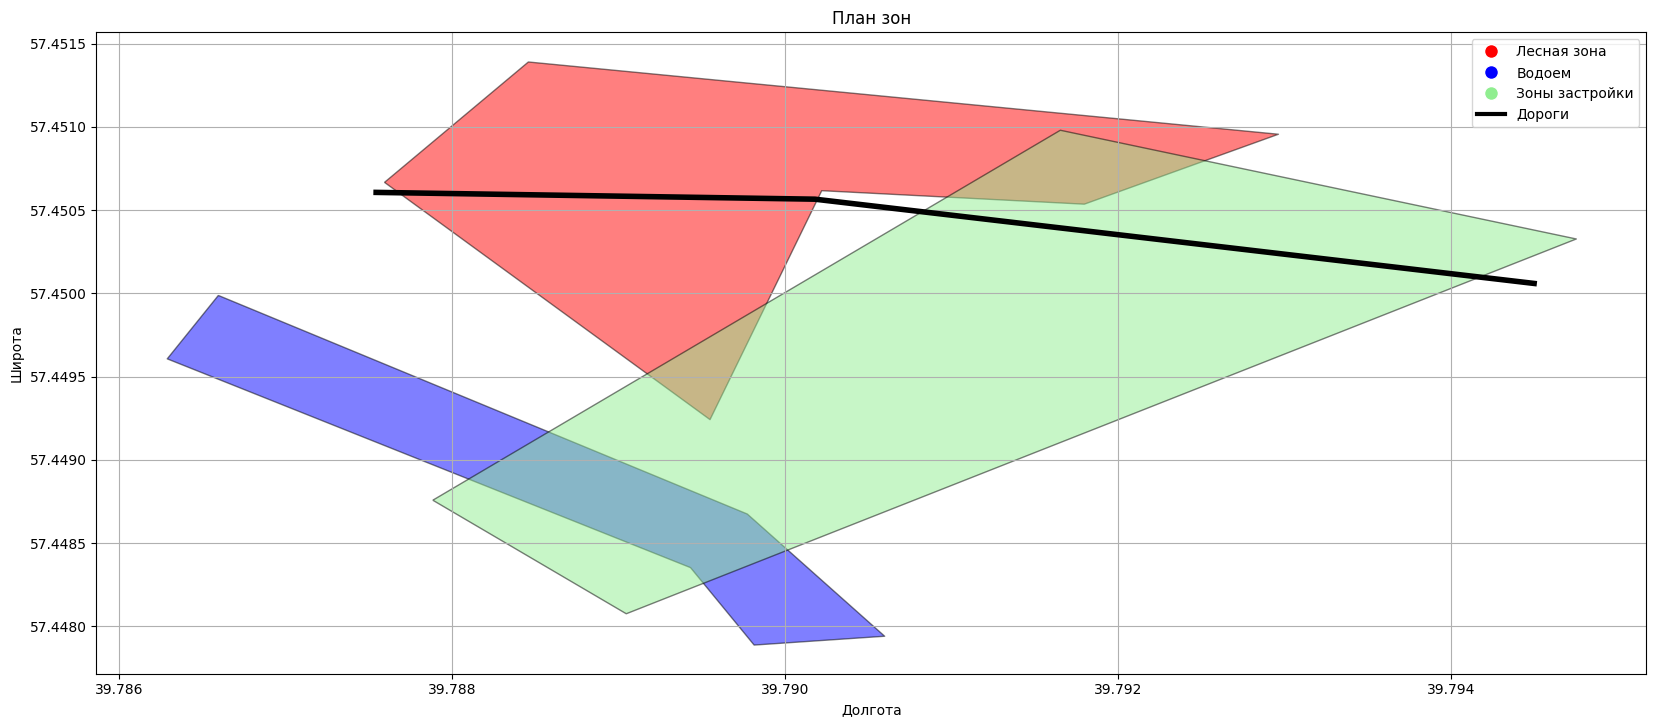

In [ ]:
plot_empty(gdf)

## 2. Функционал для размещения объектов

In [157]:
# Гиперпараметры
min_distance_parks = 0.0005 # мин. расстояние между парками (50 метров)
min_distance_houses = 0.0001 # мин. расстояние между домами (10 метров)
allowed_percent = 0.30 # допустимый максимальный процент площади для застройки
num_parks = 5 # количество размещаемых парков
park_size = 0.0005  # Размер стороны парка в метрах
house_size = 0.0001  # размер стороны дома в метрах

In [152]:
# Функция для размещения участков
def place_area(polygon, area_size, restricted_zones, placed_areas, min_distance):

    '''Функция размещает квадратные полигоны с заданной длиной стороны в границах указанной области

    Вход:
    polygon - зона застройки
    area_size - длина стороны квадрата
    restricted_zones - зона с запретом на строительство
    placed_areas - пустой список для хранения размещенных участков
    min_distance - минимальное расстояние между участками
    
    Выход:
    area - полигон с заданными координатами'''
    
    attempts = 0
    max_attempts = 1000

    minx, miny, maxx, maxy = polygon.bounds

    while attempts < max_attempts:
        x = random.uniform(minx, maxx - area_size)
        y = random.uniform(miny, maxy - area_size)

        area = box(x, y, x + area_size, y + area_size)

        if (
            polygon.contains(area) and 
            not restricted_zones.intersects(area) and 
            all(area.distance(placed_area) >= min_distance for placed_area in placed_areas)  
        ):
            return area
        
        attempts += 1
        
    return None

In [ ]:
total_area = gdf[gdf['name'] == 'Зона застройки']['geometry'][0]
restricted_zones = gdf[gdf['name'] != 'Зона застройки']['geometry']
combined_restricted_zones = restricted_zones.unary_union
allowed_area = total_area.difference(combined_restricted_zones).area

# Параметры для парков
parks = []
placed_parks = []

# Параметры для домов
houses = []
used_area = 0
placed_houses = []


# Печатаем начальные условия
print(f"Допустимая площадь: {allowed_area}\nВся площадь: {total_area.area}")

# Размещение парков
for _ in range(num_parks):
    park = place_area(total_area, park_size, combined_restricted_zones, placed_parks, min_distance_parks)
    if park:
        parks.append(park)
        placed_parks.append(park)
        used_area += park.area
# Обновляем restricted_zones с зонами парков
if parks:
    combined_park_zones = gpd.GeoSeries(parks).unary_union
    combined_restricted_zones = combined_restricted_zones.union(combined_park_zones)

# Размещение домов
while used_area < allowed_area * allowed_percent:
    house = place_area(total_area, house_size, combined_restricted_zones, placed_houses, min_distance_houses)
    
    if house:  
        houses.append(house)
        placed_houses.append(house)
        used_area += house.area
    else:
        break 


# Создаем GeoDataFrame для размещенных домов
houses_gdf = gpd.GeoDataFrame(geometry=houses, crs=gdf.crs)
houses_gdf['name'] = 'Дом'
houses_gdf['restrictions'] = None

# Создаем GeoDataFrame для размещенных парков
parks_gdf = gpd.GeoDataFrame(geometry=parks, crs=gdf.crs)
parks_gdf['name'] = 'Парк'
parks_gdf['restrictions'] = None

# Объединяем со старым GeoDataFrame
final_gdf = pd.concat([gdf, houses_gdf, parks_gdf], ignore_index=True)

# Сохранение в GeoJSON
final_gdf.to_file("site_plan.geojson", driver='GeoJSON')
percentage_used = (used_area / allowed_area) * 100
# Для подтверждения, можно вывести результат
print(f"""Занятая площадь: {used_area}
Доступная площадь: {allowed_area}
Застроено: {percentage_used:.2f}% от доступной площади.""")



C:\Users\Asus\AppData\Local\Temp\ipykernel_15376\3468055127.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_restricted_zones = restricted_zones.unary_union


Допустимая площадь: 6.688176192099185e-06
Вся площадь: 7.927144500001154e-06


C:\Users\Asus\AppData\Local\Temp\ipykernel_15376\3468055127.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_park_zones = gpd.GeoSeries(parks).unary_union


Занятая площадь: 1.4900000000562965e-06
Доступная площадь: 6.688176192099185e-06
Застроено: 22.28% от доступной площади.


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [154]:
final_gdf.head(10)

,geometry,name,restrictions
0,"POLYGON ((39.78788 57.44876, 39.78904 57.44808...",Зона застройки,None
1,"POLYGON ((39.78759 57.45067, 39.78954 57.44924...",Лесная зона,building not allowed
2,"POLYGON ((39.78659 57.44999, 39.78977 57.44868...",Водоем,building not allowed
3,"LINESTRING (39.78752 57.45061, 39.79018 57.450...",Дорога,building not allowed
4,"POLYGON ((39.78935 57.44927, 39.78935 57.44937...",Дом,None
5,"POLYGON ((39.79179 57.4501, 39.79179 57.4502, ...",Дом,None
6,"POLYGON ((39.79173 57.44962, 39.79173 57.44972...",Дом,None
7,"POLYGON ((39.79138 57.44987, 39.79138 57.44997...",Дом,None
8,"POLYGON ((39.79043 57.44979, 39.79043 57.44989...",Дом,None
9,"POLYGON ((39.79334 57.4499, 39.79334 57.45, 39...",Дом,None


## 3. Визуализация

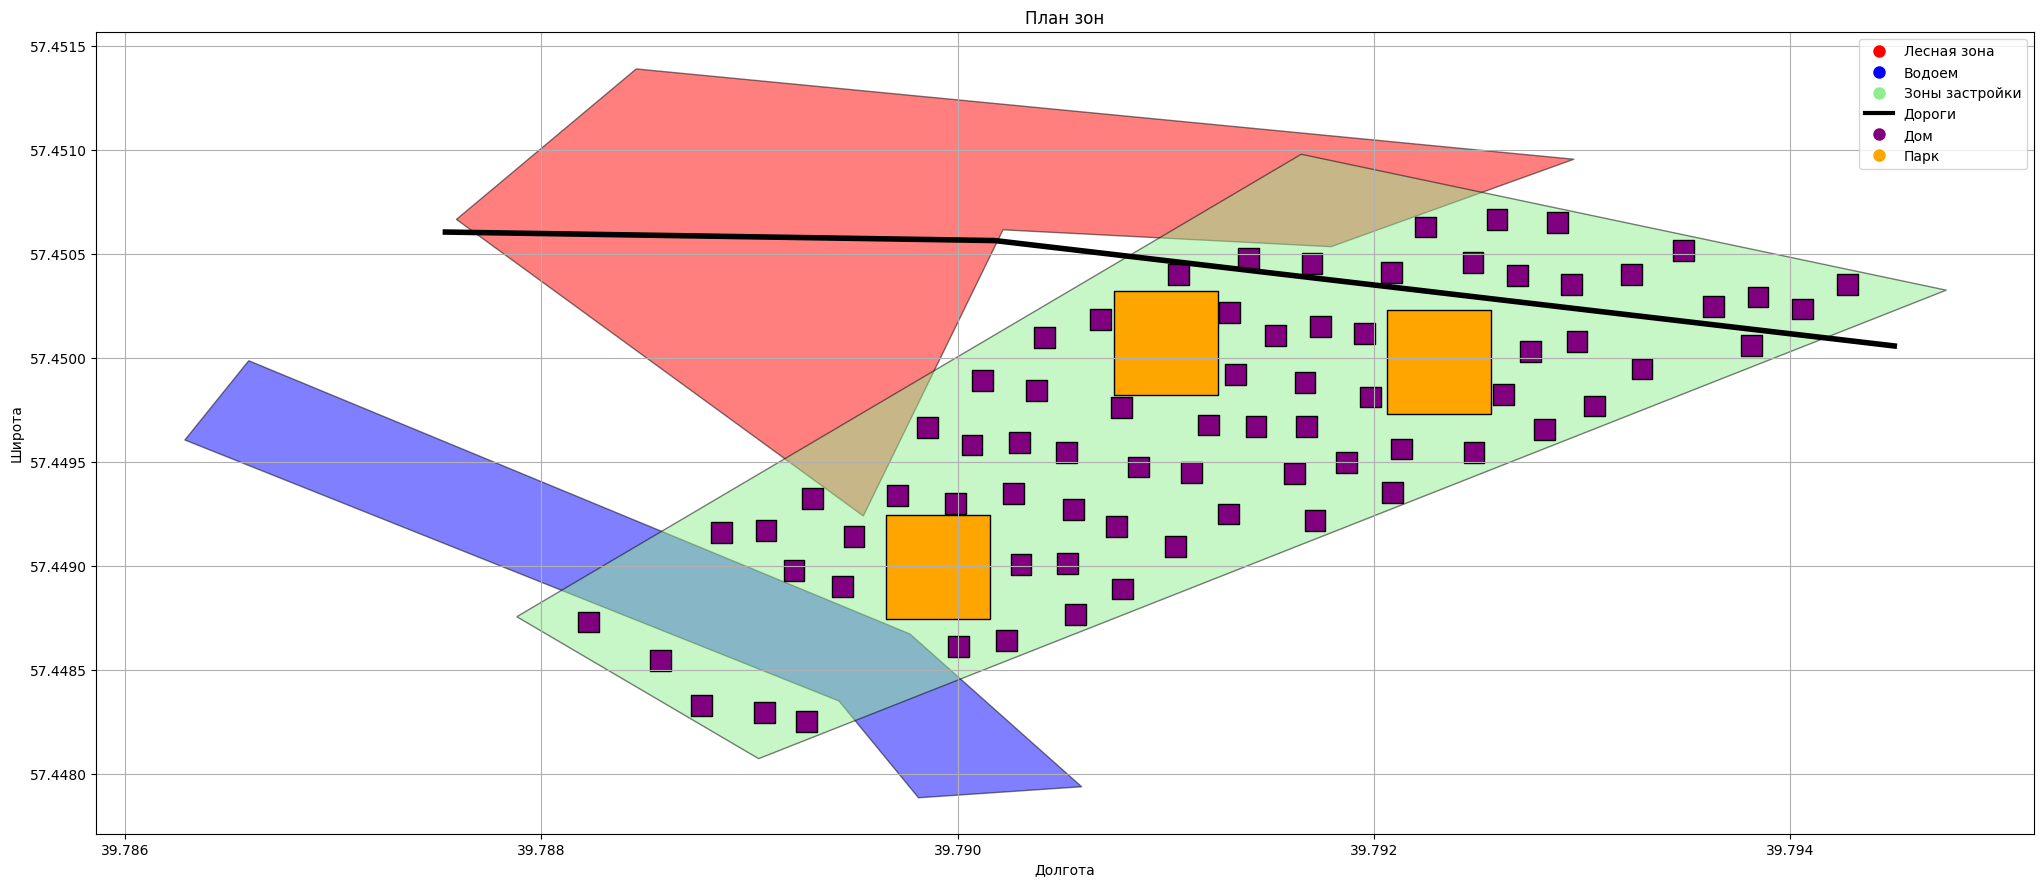

In [156]:
fig, ax = plt.subplots(figsize=(25, 45))

# Собираем зоны. Концептуальный пример, для реальной работы и зон и признаков будет больше, как я думаю
forest_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Лесная зона')]
water_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Водоем')]
building_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Зона застройки')]
roads = final_gdf[final_gdf['geometry'].type == 'LineString']
houses = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Дом')]
parks = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Парк')]

# Плотим зомы
forest_zone.plot(ax=ax, color='red', edgecolor='black', legend=False, alpha=0.5)
water_zone.plot(ax=ax, color='blue', edgecolor='black', legend=False, alpha=0.5)
roads.plot(ax=ax, color='black', linewidth=4, legend=False)
building_zone.plot(ax=ax, color='lightgreen', edgecolor='black', legend=False, alpha=0.5)
houses.plot(ax=ax, color='purple', edgecolor='black', legend=False)
parks.plot(ax=ax, color='orange', edgecolor='black', legend=False)

# Задаем легенду
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Лесная зона', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Водоем', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Зоны застройки', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], color='black', linewidth=3, label='Дороги'),
    plt.Line2D([0], [0], marker='o', color='w', label='Дом', markerfacecolor='purple', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Парк', markerfacecolor='orange', markersize=10)
]

ax.legend(handles=handles)
ax.set_title('План зон')
ax.set_xlabel('Долгота')
ax.set_ylabel('Широта')
plt.grid()
plt.show()